In [1]:
%matplotlib inline
import numpy as np
from numpy import pi
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Quantum Fourier Transfrom
The quantum fourier transform (qft) function can be implemented for $n$ qubits with the example from Qiskit textbook https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html#generalqft. The function will consist of the following steps:
<ol>
<li> 
  Encode the state about to undergo QFT into the input register, by applying X-gates to all qubits that are in the state $|1\rangle$.
</li>
<li>
  Stating from the least significant qubit at index, apply a Hadamard gate and rotations about the Z-axis controlled by the each of the remaining qubits (CROT).
</li>
<li>
  Repeat step 2 for the next least significant qubit, until you run out of qubits.
</li>
<li>
  Swap the indices of the qubits to account for reverse orderring in Qiskit.
</li>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  


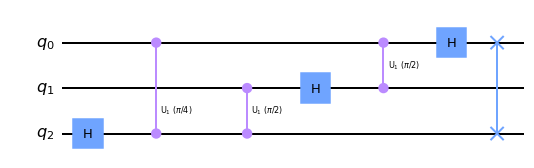

In [2]:
def qft(n):
    qc = QuantumCircuit(n)
    # Apply Hadamard and CROT-gates
    for m in range(n):
        j=n-m-1
        qc.h(j)
        for qubit in range(j):
            qc.cu1(pi/2**(j-qubit), qubit, j)
    # Swap the qubit indices
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    qc.name = " QFT"
    return qc

qft(3).draw()

Now let us build a circuit with the Fourier transform gate appended.

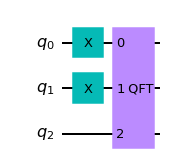

In [3]:
state = [1,1,0]
n = len(state)
qc = QuantumCircuit(n)
# Encode the binary state
for qubit in range(n):
    if state[qubit] == 1:
        qc.x(qubit)
qc.append(qft(n), qc.qubits[:n])
qc.draw()

## Testing with Simulator
First take out the statevector to verify that the Fourier transform worked.

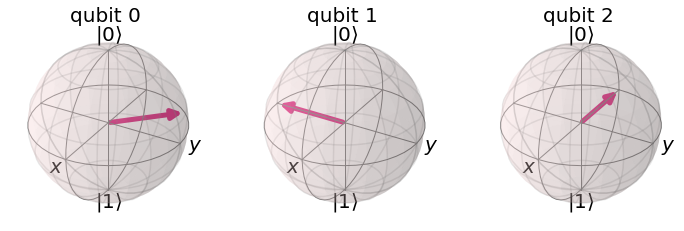

In [4]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

In order to get an answer from a real qubit device, we can run first the Fourier transform and then the inverse Fourier transform and see if we're left with the original state.

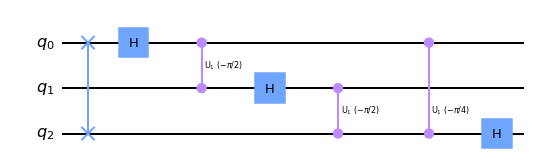

In [5]:
def inverse_qft(n):
    qft_circuit = qft(n)
    invqft_circuit = qft_circuit.inverse()
    invqft_circuit.name = " INV_QFT"
    return invqft_circuit

inverse_qft(3).draw()

Now add the inverse Fourier transform to the circuit.

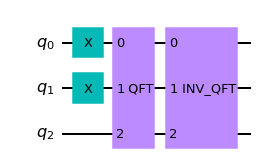

In [6]:
qc.append(inverse_qft(n), qc.qubits[:n])
qc.draw()

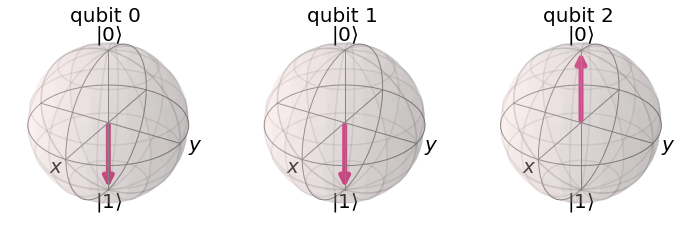

In [7]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(qc, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

## Testing on a Real Device

In [8]:
# Get the least busy backend
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory.load_account:WARNING:2020-11-30 13:09:44,266: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_athens


In [9]:
# Send job to the real device
shots = 1024
job = execute(qc, backend=backend, shots=shots, optimization_level=3)
job_monitor(job)

Job Status: job has successfully run


ValueError: max() arg is an empty sequence

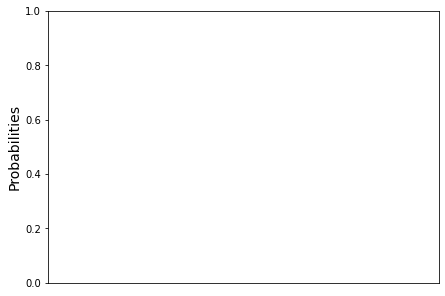

In [10]:
# Plot the results
counts = job.result().get_counts()
plot_histogram(counts)